## Facundo Facio's homework 1

### Question 1: [Index] S&P 500 Stocks Added to the Index

In [1]:
import pandas as pd

In [33]:
wikipedia_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
df =pd.read_html(
    io=wikipedia_url, 
    attrs={"id": "constituents"},
    parse_dates=["Date added"],
)[0]
df = df[["Symbol", "Security", "Date added"]].rename(
    columns={
        "Symbol": "ticker",
        "Security": "name",
        "Date added": "date_added",
    }
)
df.head()

,ticker,name,date_added
0,MMM,3M,1957-03-04
1,AOS,A. O. Smith,2017-07-26
2,ABT,Abbott Laboratories,1957-03-04
3,ABBV,AbbVie,2012-12-31
4,ACN,Accenture,2011-07-06


#### Which year had the highest number of additions (1957 doesn't count, as it was the year when the S&P 500 index was founded)?

In [48]:
# group by year added and count the number of companies added each year
df["year_added"] = df["date_added"].dt.year
df_yearly = df.groupby("year_added").size().reset_index(name="count")

higher_additions = df_yearly[df_yearly["year_added"] != 1957].sort_values(
    by="count", ascending=False).iloc[0]

print(
    f"The year with the highest number of S&P 500 additions is "
    f"{higher_additions['year_added']} with {higher_additions['count']} additions."
    )

The year with the highest number of S&P 500 additions is 2017 with 23 additions.


#### Additional: How many current S&P 500 stocks have been in the index for more than 20 years?

In [173]:
df = pd.read_html(
    io=wikipedia_url,
    attrs={"id": "changes"},
    parse_dates=[('Date', 'Date')],
)[0]
df = df[[("Date", "Date"), ("Added", "Ticker"), ("Removed", "Ticker")]].rename(
    columns={
        "Date": "date",
        "Added": "added",
        "Removed": "removed",
    }
)
df.columns = df.columns.droplevel(1)
df.head()

,date,added,removed
0,2025-05-19,COIN,DFS
1,2025-03-24,DASH,BWA
2,2025-03-24,TKO,TFX
3,2025-03-24,WSM,CE
4,2025-03-24,EXE,FMC


In [176]:
# reformat the dataframe to have one row per ticket and two columns: 'added' and 'removed'
df_melted = df.melt(
    id_vars=["date"],
    value_vars=["added", "removed"],
    var_name="action",
    value_name="ticker"
)
df_melted.head()

,date,action,ticker
0,2025-05-19,added,COIN
1,2025-03-24,added,DASH
2,2025-03-24,added,TKO
3,2025-03-24,added,WSM
4,2025-03-24,added,EXE


In [175]:
# Separate and sort
added = df_melted[df_melted['action'] == 'added'].sort_values(
    ['ticker', 'date']).copy()
removed = df_melted[df_melted['action'] == 'removed'].sort_values(
    ['ticker', 'date']).copy()

# Assign a group number per ticker for pairing
added['cycle'] = added.groupby('ticker').cumcount()
removed['cycle'] = removed.groupby('ticker').cumcount()

# Merge on ticker + cycle
result = pd.merge(
    added[['ticker', 'date']].assign(cycle=added['cycle']),
    removed[['ticker', 'date']].assign(cycle=removed['cycle']),
    on=['ticker', 'cycle'],
    how='left',
    suffixes=('_added', '_removed')
).drop(columns='cycle'
       ).dropna(subset=["ticker"])

# print(f"any column has nan?:\n{result.isna().any()}\n")

# for tickers without a removal date, set it to today's date
result['date_removed'] = result['date_removed'].fillna(pd.Timestamp.today())

# print(f"any column has nan?:\n{result.isna().any()}\n")

# add a column for the number of days in the S&P 500
result['days_in_sp500'] = (
    result['date_removed'] - result['date_added']
).dt.days

# group by ticker and get tue sum of days_in_sp500
result_grouped = result.groupby('ticker').agg(
    total_days_in_sp500=('days_in_sp500', 'sum')
).reset_index()
# sort by total_days_in_sp500 in descending order
result_grouped = result_grouped.sort_values(
    by='total_days_in_sp500', ascending=False
)
# get total_years_in_sp500
result_grouped['total_years_in_sp500'] = (
    result_grouped['total_days_in_sp500'] / 365.25
).round(2)
# count the number of tickers with more than 20 years in the S&P 500
count_more_than_20_years = (
    result_grouped[result_grouped['total_years_in_sp500'] > 20].shape[0]
)
print(
    f"There are {count_more_than_20_years} tickers with more than 20 years in the S&P 500."
)

There are 10 tickers with more than 20 years in the S&P 500.


### Question 2. [Macro] Indexes YTD (as of 1 May 2025)

[*********************100%***********************]  11 of 11 completed

S&P 500 YTD return as of May 1, 2025: -5.10%

Indexes with better YTD returns than the US:
- China: 0.50%
- Hong Kong: 12.72%
- Australia: -0.91%
- India: 2.49%
- Canada: -0.23%
- Germany: 12.35%
- United Kingdom: 2.84%
- Mexico: 13.05%
- Brazil: 12.44%

Answer: 9 indexes had better YTD returns than the US.


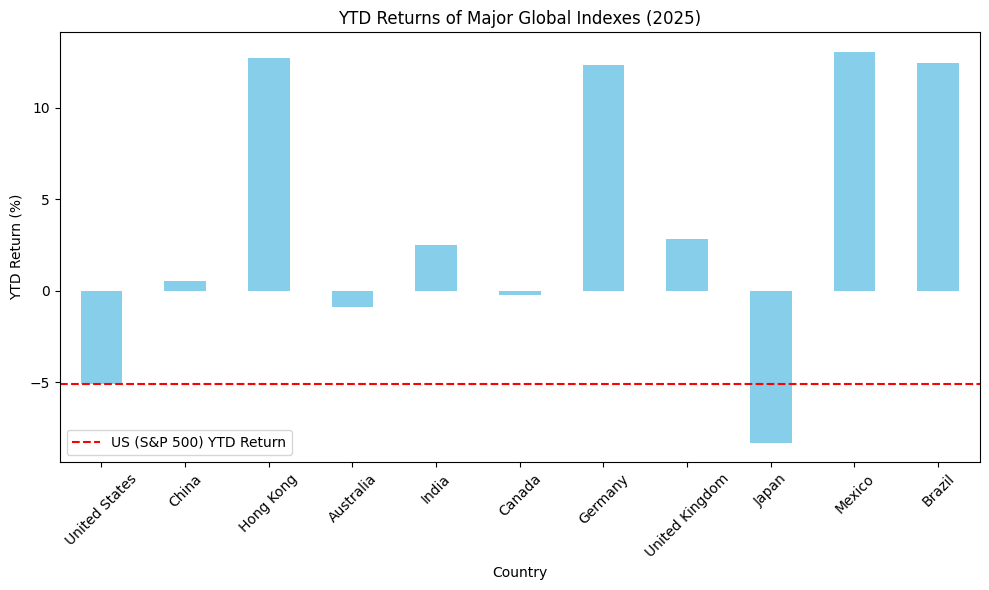

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Index tickers (Yahoo Finance format)
tickers = {
    "United States": "^GSPC",
    "China": "000001.SS",
    "Hong Kong": "^HSI",
    "Australia": "^AXJO",
    "India": "^NSEI",
    "Canada": "^GSPTSE",
    "Germany": "^GDAXI",
    "United Kingdom": "^FTSE",
    "Japan": "^N225",
    "Mexico": "^MXX",
    "Brazil": "^BVSP"
}

start = "2025-01-01"
end = "2025-05-01"

# Download adjusted close prices
data = yf.download(list(tickers.values()), start=start,
                   end=end, interval="1d")["Close"]

# Calculate YTD returns: (last_price - first_price) / first_price
ytd_returns = (
    (data.bfill().iloc[-1] - data.bfill().iloc[0]) / data.bfill().iloc[0]) * 100

# Map tickers back to country names
country_returns = {country: ytd_returns[ticker]
                   for country, ticker in tickers.items()}

# Compare to US (S&P 500)
us_return = country_returns["United States"]
better_than_us = {country: ret for country, ret in country_returns.items(
) if country != "United States" and ret > us_return}

# Print summary
print(f"S&P 500 YTD return as of May 1, 2025: {us_return:.2f}%")
print("\nIndexes with better YTD returns than the US:")
for country, ret in better_than_us.items():
    print(f"- {country}: {ret:.2f}%")

print(
    f"\nAnswer: {len(better_than_us)} indexes had better YTD returns than the US.")

# plot the YTD returns per country
plt.figure(figsize=(10, 6))
country_returns_series = pd.Series(country_returns)
country_returns_series.plot(kind='bar', color='skyblue')
plt.axhline(y=us_return, color='red', linestyle='--',
            label='US (S&P 500) YTD Return')
plt.title('YTD Returns of Major Global Indexes (2025)')
plt.xlabel('Country')
plt.ylabel('YTD Return (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### Additional: How many of these indexes have better returns than the S&P 500 over 3, 5, and 10 year periods? Do you see the same trend?

In [52]:
# How many of these indexes have better returns than the S&P 500 over 3, 5, and 10 year periods? Do you see the same trend?
# Download historical data for the same tickers
historical_data = yf.download(
    list(tickers.values()), start="2015-01-01", end="2025-01-01", interval="1d")["Close"].bfill().ffill()
# Calculate returns for 3, 5, and 10 years
def calculate_returns(data, years):
    start_date = data.index[-years * 252]  # Assuming 252 trading days per year
    end_date = data.index[-1]
    start_price = data.loc[start_date]
    end_price = data.loc[end_date]
    return (end_price - start_price) / start_price * 100
returns_3y = historical_data.apply(lambda x: calculate_returns(x, 3))
returns_5y = historical_data.apply(lambda x: calculate_returns(x, 5))
returns_10y = historical_data.apply(lambda x: calculate_returns(x, 10))
# Combine returns into a DataFrame
returns_df = pd.DataFrame({
    '3Y Return': returns_3y,
    '5Y Return': returns_5y,
    '10Y Return': returns_10y
})
# Compare to US (S&P 500)
us_3y = returns_df.loc['^GSPC', '3Y Return']
us_5y = returns_df.loc['^GSPC', '5Y Return']
us_10y = returns_df.loc['^GSPC', '10Y Return']
better_than_us_3y = returns_df[returns_df['3Y Return'] > us_3y]
better_than_us_5y = returns_df[returns_df['5Y Return'] > us_5y]
better_than_us_10y = returns_df[returns_df['10Y Return'] > us_10y]
# Print summary
print(f"\nS&P 500 3Y return: {us_3y:.2f}%")
print(f"S&P 500 5Y return: {us_5y:.2f}%")
print(f"S&P 500 10Y return: {us_10y:.2f}%")
print("\nIndexes with better 3Y returns than the US:")
for country, ret in better_than_us_3y['3Y Return'].items():
    print(f"- {country}: {ret:.2f}%")
print("\nIndexes with better 5Y returns than the US:")
for country, ret in better_than_us_5y['5Y Return'].items():
    print(f"- {country}: {ret:.2f}%")
print("\nIndexes with better 10Y returns than the US:")
for country, ret in better_than_us_10y['10Y Return'].items():
    print(f"- {country}: {ret:.2f}%")
# Print the number of indexes with better returns than the S&P 500
print(f"\nAnswer:\n{len(better_than_us_3y)} indexes had better 3Y returns than the US.")
print(f"{len(better_than_us_5y)} indexes had better 5Y returns than the US.")
print(f"{len(better_than_us_10y)} indexes had better 10Y returns than the US.")

[*********************100%***********************]  11 of 11 completed


S&P 500 3Y return: 30.08%
S&P 500 5Y return: 87.90%
S&P 500 10Y return: 178.98%

Indexes with better 3Y returns than the US:
- ^GDAXI: 30.62%
- ^N225: 46.22%
- ^NSEI: 36.94%

Indexes with better 5Y returns than the US:
- ^N225: 89.07%
- ^NSEI: 110.16%

Indexes with better 10Y returns than the US:
- ^NSEI: 183.78%

Answer:
3 indexes had better 3Y returns than the US.
2 indexes had better 5Y returns than the US.
1 indexes had better 10Y returns than the US.


### Question 3. [Index] S&P 500 Market Corrections Analysis

In [ ]:
import yfinance as yf
import pandas as pd
# import numpy as np

# Step 1: Download S&P 500 data since 1950
df = yf.download("^GSPC", start="1950-01-01")["Close"].bfill().ffill()
df = df.dropna()

# Step 2: Identify all-time highs
all_time_highs = df[df.cummax() == df]

# Step 3: For each pair of consecutive ATHs, find the min price in between
corrections = []

ath_dates = all_time_highs.index.tolist()

for i in range(len(ath_dates) - 1):
    start = ath_dates[i]
    end = ath_dates[i + 1]

    window = df.loc[start:end]
    if len(window) < 2:
        continue

    peak_price = df.loc[start].item()
    min_price = window.min().item()
    min_date = window.idxmin().item()

    drawdown = (peak_price - min_price) / peak_price * 100

    if drawdown >= 5:
        duration = (end - start).days
        corrections.append({
            "start": start,
            "end": end,
            "low_date": min_date,
            "drawdown_pct": drawdown,
            "duration_days": duration
        })


# Step 6–7: Create DataFrame and compute percentiles
corrections_df = pd.DataFrame(corrections)

percentiles = corrections_df["duration_days"].quantile([0.25, 0.5, 0.75])

print("Significant S&P 500 Corrections (Drawdown > 5%) Duration Percentiles (in days):\n")
print(percentiles.to_string(float_format="%.0f"))

[*********************100%***********************]  1 of 1 completed


Significant S&P 500 Corrections (Drawdown > 5%) Duration Percentiles (in days):

0.25   1
0.50   1
0.75   3


In [18]:
corrections_df

,start,end,low_date,drawdown_pct,duration_days
0,1950-06-23,1950-06-26,1950-06-26,5.381394,3
1,1955-09-23,1955-09-26,1955-09-26,6.618454,3
2,1962-05-25,1962-05-28,1962-05-28,6.675637,3
3,1987-10-15,1987-10-16,1987-10-16,5.159680,1
4,1987-10-16,1987-10-19,1987-10-19,20.466931,3
5,1987-10-23,1987-10-26,1987-10-26,8.278947,3
6,1988-01-07,1988-01-08,1988-01-08,6.768305,1
7,1989-10-12,1989-10-13,1989-10-13,6.117229,1
8,1997-10-24,1997-10-27,1997-10-27,6.865684,3
9,1998-08-28,1998-08-31,1998-08-31,6.801408,3
